# Inside Airbnb NYC - Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

print("="*80)
print("INSIDE AIRBNB NYC - DATA LOADING GUIDE")
print("="*80)

INSIDE AIRBNB NYC - DATA LOADING GUIDE


# STEP 1: LOAD THE DETAILED LISTINGS DATA

In [2]:
def load_detailed_listings(filepath='data/calendar.csv.gz'):
    """
    Load the detailed listings file (THIS IS THE ONE YOU NEED!)
    
    File: listings.csv.gz (or listings.csv if unzipped)
    Size: ~40,000 rows × 74 columns
    """
    print("\n" + "="*80)
    print("LOADING DETAILED LISTINGS DATA")
    print("="*80)
    
    try:
        # Try compressed version first
        df = pd.read_csv(filepath, compression='gzip' if filepath.endswith('.gz') else None)
        print(f"✅ Successfully loaded: {filepath}")
        print(f"   Shape: {df.shape[0]:,} listings × {df.shape[1]} columns")
        return df
    
    except FileNotFoundError:
        print(f"❌ File not found: {filepath}")
        print("\nMake sure you've downloaded 'listings.csv.gz' from:")
        print("   http://insideairbnb.com/get-the-data/")
        print("\nAnd placed it in the same folder as this notebook.")
        return None
    
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None

# STEP 2: UNDERSTAND THE COLUMN STRUCTURE

In [3]:
def explore_columns(df):
    """
    Understand what columns are available and their data types
    """
    print("\n" + "="*80)
    print("COLUMN INVENTORY")
    print("="*80)
    
    print(f"\nTotal columns: {len(df.columns)}\n")
    
    # Group columns by category
    column_categories = {
        'ID & Basic Info': [],
        'Location': [],
        'Property Details': [],
        'Host Information': [],
        'Pricing': [],
        'Availability': [],
        'Reviews': [],
        'Other': []
    }
    
    for col in df.columns:
        col_lower = col.lower()
        
        if col in ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'picture_url']:
            column_categories['ID & Basic Info'].append(col)
        elif any(word in col_lower for word in ['neighbourhood', 'latitude', 'longitude', 'city', 'state', 'zipcode', 'country']):
            column_categories['Location'].append(col)
        elif any(word in col_lower for word in ['room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'property_type']):
            column_categories['Property Details'].append(col)
        elif any(word in col_lower for word in ['host_', 'host']):
            column_categories['Host Information'].append(col)
        elif any(word in col_lower for word in ['price', 'fee', 'deposit', 'minimum_nights', 'maximum_nights']):
            column_categories['Pricing'].append(col)
        elif any(word in col_lower for word in ['availability', 'calendar']):
            column_categories['Availability'].append(col)
        elif any(word in col_lower for word in ['review', 'rating', 'score']):
            column_categories['Reviews'].append(col)
        else:
            column_categories['Other'].append(col)
    
    for category, columns in column_categories.items():
        if columns:
            print(f"\n📁 {category} ({len(columns)} columns):")
            for col in columns:
                dtype = df[col].dtype
                missing_pct = (df[col].isnull().sum() / len(df) * 100)
                print(f"   - {col:<30} [{dtype}] {missing_pct:>5.1f}% missing")
    
    return column_categories

# STEP 3: QUICK DATA QUALITY CHECK

In [4]:
def quick_quality_check(df):
    """
    Check for common data quality issues
    """
    print("\n" + "="*80)
    print("DATA QUALITY CHECK")
    print("="*80)
    
    # Check 1: Price column
    if 'price' in df.columns:
        print("\n✓ Price Column:")
        print(f"   Data type: {df['price'].dtype}")
        
        # Check if price needs cleaning
        if df['price'].dtype == 'object':
            print("   ⚠️  Price is stored as text (contains $, commas)")
            sample_prices = df['price'].head()
            print(f"   Sample values: {sample_prices.tolist()}")
            print("   → Will need to clean (remove $, convert to float)")
        else:
            print("   ✅ Price is numeric")
            print(f"   Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
    
    # Check 2: Neighborhood column
    neighborhood_col = None
    if 'neighbourhood_cleansed' in df.columns:
        neighborhood_col = 'neighbourhood_cleansed'
    elif 'neighbourhood' in df.columns:
        neighborhood_col = 'neighbourhood'
    
    if neighborhood_col:
        print(f"\n✓ Neighborhood Column: '{neighborhood_col}'")
        n_neighborhoods = df[neighborhood_col].nunique()
        print(f"   Number of unique neighborhoods: {n_neighborhoods}")
        print(f"   Top 5 neighborhoods by listing count:")
        top_5 = df[neighborhood_col].value_counts().head()
        for hood, count in top_5.items():
            print(f"      {hood:<30} {count:>6,} listings")
    
    # Check 3: Room type
    if 'room_type' in df.columns:
        print(f"\n✓ Room Types:")
        room_types = df['room_type'].value_counts()
        for room_type, count in room_types.items():
            pct = count / len(df) * 100
            print(f"   {room_type:<30} {count:>6,} ({pct:.1f}%)")
    
    # Check 4: Key numeric features
    print(f"\n✓ Key Numeric Features:")
    numeric_features = ['accommodates', 'bedrooms', 'beds', 'bathrooms_text', 'number_of_reviews']
    for feature in numeric_features:
        if feature in df.columns:
            missing = df[feature].isnull().sum()
            missing_pct = missing / len(df) * 100
            if missing_pct > 0:
                print(f"   {feature:<25} ⚠️  {missing:>5,} missing ({missing_pct:.1f}%)")
            else:
                print(f"   {feature:<25} ✅ No missing values")
    
    # Check 5: Overall missing data
    print(f"\n✓ Overall Missing Data:")
    total_missing = df.isnull().sum().sum()
    total_cells = df.shape[0] * df.shape[1]
    missing_pct = total_missing / total_cells * 100
    print(f"   Total cells: {total_cells:,}")
    print(f"   Missing cells: {total_missing:,} ({missing_pct:.2f}%)")
    
    # Columns with high missing data
    high_missing = df.columns[df.isnull().sum() / len(df) > 0.5]
    if len(high_missing) > 0:
        print(f"\n   ⚠️  Columns with >50% missing data ({len(high_missing)} columns):")
        for col in high_missing:
            missing_pct = df[col].isnull().sum() / len(df) * 100
            print(f"      {col:<30} {missing_pct:.1f}% missing")

# STEP 4: EXPLORE NEIGHBORHOODS (FOR SCOPING DECISION)


In [5]:
def explore_neighborhoods(df):
    """
    Detailed neighborhood analysis to help you choose which ones to focus on
    """
    print("\n" + "="*80)
    print("NEIGHBORHOOD ANALYSIS (FOR SCOPING)")
    print("="*80)
    
    neighborhood_col = 'neighbourhood_cleansed' if 'neighbourhood_cleansed' in df.columns else 'neighbourhood'
    
    if neighborhood_col not in df.columns:
        print("❌ Neighborhood column not found!")
        return None
    
    # Clean price for analysis
    if df['price'].dtype == 'object':
        df['price_numeric'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)
    else:
        df['price_numeric'] = df['price']
    
    # Calculate neighborhood statistics
    neighborhood_stats = df.groupby(neighborhood_col).agg({
        'id': 'count',
        'price_numeric': ['mean', 'median', 'std'],
        'number_of_reviews': 'mean',
        'availability_365': 'mean'
    }).round(2)
    
    neighborhood_stats.columns = ['count', 'avg_price', 'median_price', 'std_price', 'avg_reviews', 'avg_availability']
    neighborhood_stats = neighborhood_stats.sort_values('count', ascending=False)
    
    print("\n📊 Top 20 Neighborhoods by Listing Count:")
    print("="*80)
    print(f"{'Neighborhood':<30} {'Count':>8} {'Avg Price':>10} {'Med Price':>10} {'Avg Reviews':>12}")
    print("-"*80)
    
    for idx, row in neighborhood_stats.head(20).iterrows():
        print(f"{idx:<30} {int(row['count']):>8,} ${row['avg_price']:>9.2f} ${row['median_price']:>9.2f} {row['avg_reviews']:>11.1f}")
    
    # Visualize top neighborhoods
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Listing count
    top_n = neighborhood_stats.head(15)
    axes[0, 0].barh(range(len(top_n)), top_n['count'])
    axes[0, 0].set_yticks(range(len(top_n)))
    axes[0, 0].set_yticklabels(top_n.index)
    axes[0, 0].set_xlabel('Number of Listings')
    axes[0, 0].set_title('Top 15 Neighborhoods by Listing Count')
    axes[0, 0].invert_yaxis()
    
    # Plot 2: Average price
    top_n_sorted = top_n.sort_values('avg_price', ascending=True)
    axes[0, 1].barh(range(len(top_n_sorted)), top_n_sorted['avg_price'], color='green')
    axes[0, 1].set_yticks(range(len(top_n_sorted)))
    axes[0, 1].set_yticklabels(top_n_sorted.index)
    axes[0, 1].set_xlabel('Average Price ($)')
    axes[0, 1].set_title('Average Price by Neighborhood')
    axes[0, 1].invert_yaxis()
    
    # Plot 3: Price distribution for top 5 neighborhoods
    top_5_hoods = neighborhood_stats.head(5).index
    df_top5 = df[df[neighborhood_col].isin(top_5_hoods)]
    df_top5.boxplot(column='price_numeric', by=neighborhood_col, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Neighborhood')
    axes[1, 0].set_ylabel('Price ($)')
    axes[1, 0].set_title('Price Distribution - Top 5 Neighborhoods')
    axes[1, 0].set_ylim(0, 500)  # Cap for visibility
    plt.sca(axes[1, 0])
    plt.xticks(rotation=45, ha='right')
    
    # Plot 4: Scatter - avg price vs count
    axes[1, 1].scatter(neighborhood_stats['count'], neighborhood_stats['avg_price'], alpha=0.6)
    axes[1, 1].set_xlabel('Number of Listings')
    axes[1, 1].set_ylabel('Average Price ($)')
    axes[1, 1].set_title('Listing Count vs Average Price')
    
    # Annotate top neighborhoods
    for idx, row in neighborhood_stats.head(10).iterrows():
        axes[1, 1].annotate(idx, (row['count'], row['avg_price']), 
                           fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Recommendations
    print("\n" + "="*80)
    print("NEIGHBORHOOD SELECTION RECOMMENDATIONS")
    print("="*80)
    
    # Find diverse neighborhoods
    high_end = neighborhood_stats.nlargest(5, 'avg_price')
    mid_range = neighborhood_stats.iloc[len(neighborhood_stats)//3:len(neighborhood_stats)//3+5]
    budget = neighborhood_stats.nsmallest(5, 'avg_price')
    
    print("\n💰 HIGH-END NEIGHBORHOODS (Luxury):")
    for idx, row in high_end.iterrows():
        if row['count'] >= 100:  # Ensure sufficient data
            print(f"   {idx:<30} {int(row['count']):>5} listings, Avg: ${row['avg_price']:.2f}")
    
    print("\n🏠 MID-RANGE NEIGHBORHOODS:")
    for idx, row in mid_range.iterrows():
        if row['count'] >= 200:
            print(f"   {idx:<30} {int(row['count']):>5} listings, Avg: ${row['avg_price']:.2f}")
    
    print("\n💵 BUDGET NEIGHBORHOODS:")
    for idx, row in budget.iterrows():
        if row['count'] >= 100:
            print(f"   {idx:<30} {int(row['count']):>5} listings, Avg: ${row['avg_price']:.2f}")
    
    print("\n✅ SUGGESTED COMBINATIONS FOR YOUR PROJECT:")
    print("   Option 1 (Price Diversity):")
    
    # Find good examples
    suggestions = []
    for idx, row in high_end.iterrows():
        if row['count'] >= 200:
            suggestions.append(f"      - {idx} (High-end, ${row['avg_price']:.0f}, {int(row['count'])} listings)")
            break
    
    for idx, row in neighborhood_stats.iterrows():
        if 150 <= row['avg_price'] <= 250 and row['count'] >= 300:
            suggestions.append(f"      - {idx} (Mid-range, ${row['avg_price']:.0f}, {int(row['count'])} listings)")
            break
    
    for idx, row in budget.iterrows():
        if row['count'] >= 200:
            suggestions.append(f"      - {idx} (Budget, ${row['avg_price']:.0f}, {int(row['count'])} listings)")
            break
    
    for suggestion in suggestions:
        print(suggestion)
    
    print("\n   Option 2 (Geographic Diversity - if borough info available):")
    print("      - Manhattan (any high-volume neighborhood)")
    print("      - Brooklyn (any high-volume neighborhood)")  
    print("      - Queens (any high-volume neighborhood)")
    
    return neighborhood_stats

# STEP 5: LOAD SUPPLEMENTARY DATA (OPTIONAL)

In [6]:
def load_supplementary_data():
    """
    Load calendar and reviews data (optional - for advanced analysis)
    """
    print("\n" + "="*80)
    print("SUPPLEMENTARY DATA (OPTIONAL)")
    print("="*80)
    
    # Calendar data
    print("\n📅 Calendar Data (calendar.csv.gz):")
    print("   Contains: Future availability and daily prices")
    print("   Use case: Temporal price analysis, seasonality")
    print("   Size: ~14M rows (365 days × 40K listings)")
    print("   💡 Tip: Only load if you want to analyze pricing trends over time")
    
    # Reviews data
    print("\n📝 Reviews Data (reviews.csv.gz):")
    print("   Contains: Individual review text and dates")
    print("   Use case: Sentiment analysis, review trends")
    print("   Size: ~1.5M reviews")
    print("   💡 Tip: Only load if you want to do text analysis")
    
    # Neighborhoods geojson
    print("\n🗺️  Neighborhoods GeoJSON (neighbourhoods.geojson):")
    print("   Contains: Geographic boundaries for mapping")
    print("   Use case: Create map visualizations")
    print("   💡 Tip: Great for presentation visuals, but not required")
    
    print("\n⚠️  For your project, the detailed listings.csv.gz is sufficient!")


# MAIN EXECUTION


🎯 GOAL: Understand your data before running the main analysis pipeline


LOADING DETAILED LISTINGS DATA
✅ Successfully loaded: /Users/theomthakur/Documents/NYU/Semester 3/Data Science and AI for Business/Project/data/listings.csv.gz
   Shape: 36,111 listings × 79 columns

COLUMN INVENTORY

Total columns: 79


📁 ID & Basic Info (7 columns):
   - id                             [int64]   0.0% missing
   - listing_url                    [object]   0.0% missing
   - scrape_id                      [int64]   0.0% missing
   - last_scraped                   [object]   0.0% missing
   - name                           [object]   0.0% missing
   - description                    [object]   2.7% missing
   - picture_url                    [object]   0.0% missing

📁 Location (6 columns):
   - host_neighbourhood             [object]  23.5% missing
   - neighbourhood                  [object]  48.2% missing
   - neighbourhood_cleansed         [object]   0.0% missing
   - neighbourhood_group_cleansed 

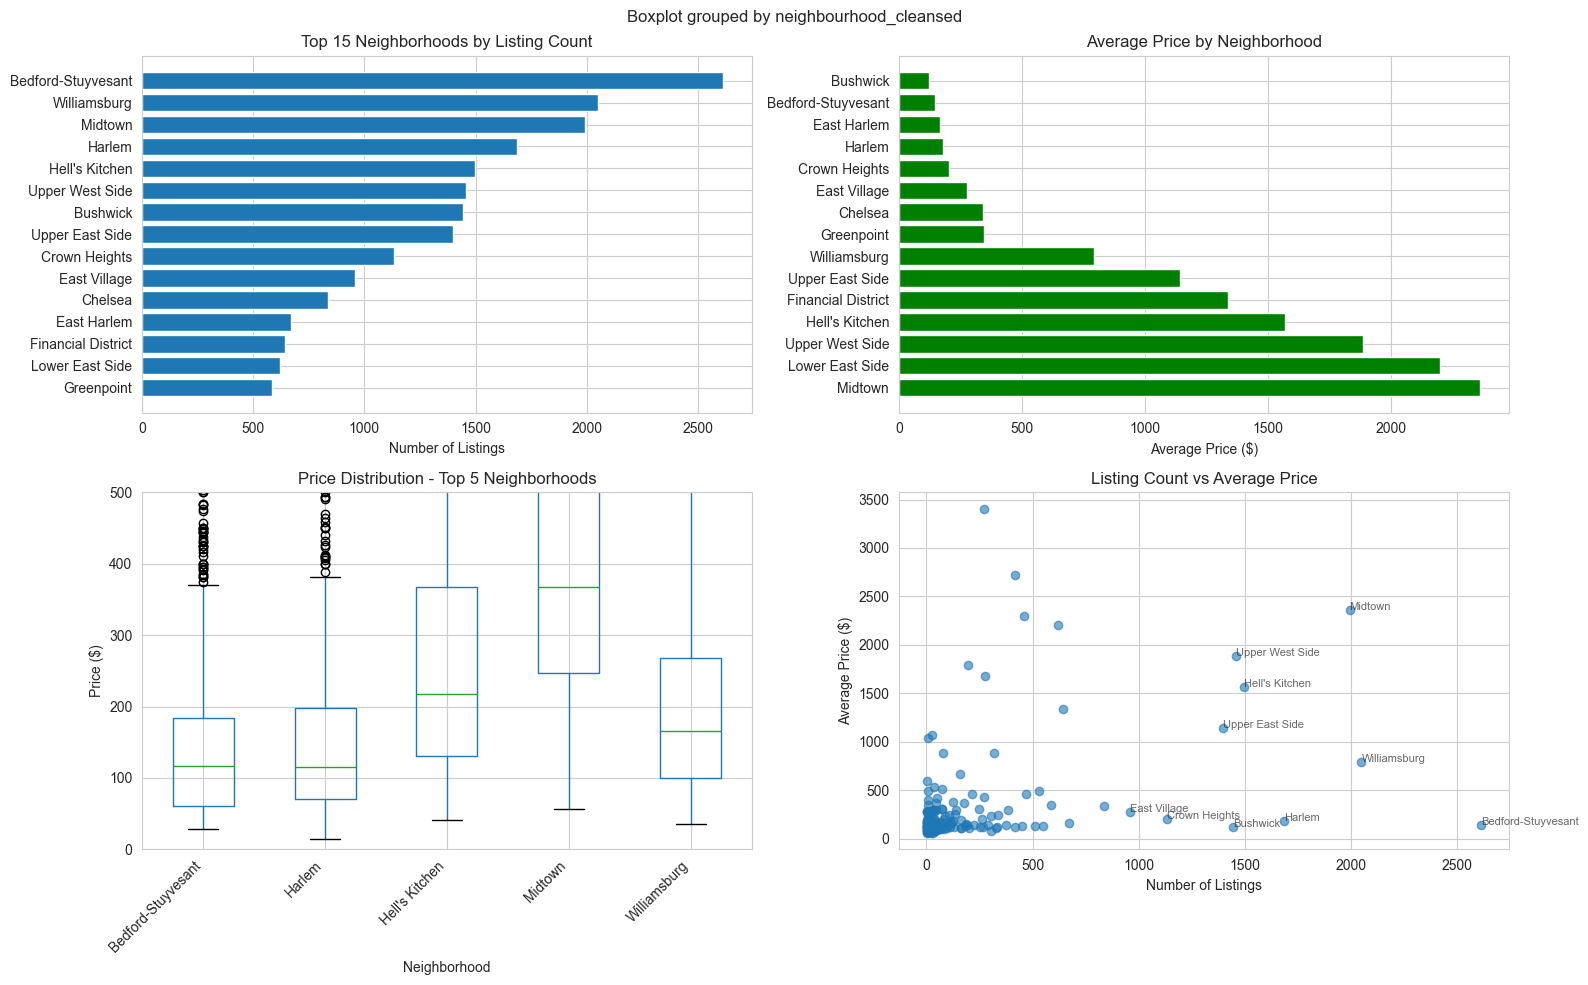


NEIGHBORHOOD SELECTION RECOMMENDATIONS

💰 HIGH-END NEIGHBORHOODS (Luxury):
   SoHo                             269 listings, Avg: $3406.56
   Long Island City                 417 listings, Avg: $2720.72
   Midtown                         1993 listings, Avg: $2360.96
   Murray Hill                      460 listings, Avg: $2299.96
   Lower East Side                  619 listings, Avg: $2201.35

🏠 MID-RANGE NEIGHBORHOODS:

💵 BUDGET NEIGHBORHOODS:

✅ SUGGESTED COMBINATIONS FOR YOUR PROJECT:
   Option 1 (Price Diversity):
      - SoHo (High-end, $3407, 269 listings)
      - Harlem (Mid-range, $178, 1685 listings)

   Option 2 (Geographic Diversity - if borough info available):
      - Manhattan (any high-volume neighborhood)
      - Brooklyn (any high-volume neighborhood)
      - Queens (any high-volume neighborhood)

SUPPLEMENTARY DATA (OPTIONAL)

📅 Calendar Data (calendar.csv.gz):
   Contains: Future availability and daily prices
   Use case: Temporal price analysis, seasonality
   Size:

In [7]:
if __name__ == "__main__":
    
    print("\n🎯 GOAL: Understand your data before running the main analysis pipeline\n")
    
    # Step 1: Load data
    df = load_detailed_listings('/Users/theomthakur/Documents/NYU/Semester 3/Data Science and AI for Business/Project/data/listings.csv.gz')
    
    if df is None:
        print("\n❌ Could not load data. Please check the file path and try again.")
    else:
        # Step 2: Explore columns
        column_categories = explore_columns(df)
        
        # Step 3: Quality check
        quick_quality_check(df)
        
        # Step 4: Neighborhood analysis (IMPORTANT FOR SCOPING!)
        neighborhood_stats = explore_neighborhoods(df)
        
        # Step 5: Info about supplementary data
        load_supplementary_data()
        
        # Final summary
        print("\n" + "="*80)
        print("NEXT STEPS")
        print("="*80)
        print("\n1. ✅ Review the neighborhood recommendations above")
        print("2. ✅ Choose 2-3 neighborhoods for your analysis")
        print("3. ✅ Update the main pipeline code with your chosen neighborhoods:")
        print("      target_neighborhoods = ['Your', 'Chosen', 'Neighborhoods']")
        print("4. ✅ Run the complete pipeline: run_complete_pipeline()")
        print("\n🚀 You're ready to start your analysis!")
        
        # Return the dataframe for further exploration if running in notebook
        print(f"\n💡 Tip: The dataframe is stored in variable 'df' if you want to explore more")
        print(f"   Example: df['price'].describe()")
        print(f"   Example: df[df['neighbourhood_cleansed'] == 'Williamsburg'].head()")